# 全国计算机应用大赛住房租金预测大数据比赛

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
#import lightgbm as lgb
import seaborn as sns
import math
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
#首先是读入文件，本题提供的文件类型是csv的
#执行下列语句，将训练集和测试集文件写入
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.describe() #查看几行数量

,时间,小区名,小区房屋出租数量,楼层,总楼层,房屋面积,居住状态,卧室数量,厅的数量,卫的数量,出租方式,区,位置,地铁线路,地铁站点,距离,装修情况,月租金
count,196539.000000,196539.000000,195538.000000,196539.000000,196539.000000,196539.000000,20138.000000,196539.000000,196539.000000,196539.000000,24230.000000,196508.000000,196508.000000,91778.000000,91778.000000,91778.000000,18492.000000,196539.000000
mean,2.115229,3224.116562,0.124151,0.955449,0.408711,0.013139,2.725196,2.236635,1.299625,1.223818,0.900289,7.905139,67.945982,3.284850,57.493735,0.551202,3.589228,7.949313
std,0.786980,2023.073726,0.133299,0.851511,0.183100,0.008104,0.667763,0.896961,0.613169,0.487234,0.299621,4.025696,43.522394,1.477147,35.191414,0.247268,1.996912,6.310609
min,1.000000,0.000000,0.007812,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.001667,1.000000,0.000000
25%,1.000000,1388.000000,0.039062,0.000000,0.290909,0.009268,3.000000,2.000000,1.000000,1.000000,1.000000,4.000000,33.000000,2.000000,23.000000,0.356667,2.000000,4.923599
50%,2.000000,3086.000000,0.082031,1.000000,0.418182,0.012910,3.000000,2.000000,1.000000,1.000000,1.000000,9.000000,61.000000,4.000000,59.000000,0.554167,2.000000,6.621392
75%,3.000000,5199.000000,0.160156,2.000000,0.563636,0.014896,3.000000,3.000000,2.000000,1.000000,1.000000,11.000000,103.000000,5.000000,87.000000,0.745833,6.000000,8.998302
max,3.000000,6627.000000,1.000000,2.000000,1.000000,1.000000,3.000000,11.000000,8.000000,8.000000,1.000000,14.000000,152.000000,5.000000,119.000000,1.000000,6.000000,100.000000


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196539 entries, 0 to 196538
Data columns (total 19 columns):
时间          196539 non-null int64
小区名         196539 non-null int64
小区房屋出租数量    195538 non-null float64
楼层          196539 non-null int64
总楼层         196539 non-null float64
房屋面积        196539 non-null float64
房屋朝向        196539 non-null object
居住状态        20138 non-null float64
卧室数量        196539 non-null int64
厅的数量        196539 non-null int64
卫的数量        196539 non-null int64
出租方式        24230 non-null float64
区           196508 non-null float64
位置          196508 non-null float64
地铁线路        91778 non-null float64
地铁站点        91778 non-null float64
距离          91778 non-null float64
装修情况        18492 non-null float64
月租金         196539 non-null float64
dtypes: float64(12), int64(6), object(1)
memory usage: 28.5+ MB


In [4]:
missed_num = train_data.isnull().sum()
print(missed_num[missed_num>0].sort_values(ascending=False))

装修情况        178047
居住状态        176401
出租方式        172309
距离          104761
地铁站点        104761
地铁线路        104761
小区房屋出租数量      1001
位置              31
区               31
dtype: int64


In [5]:
#使用corr进行相关性计算
corr = train_data.corr()
print(corr['月租金'].sort_values(ascending=False)[:5])
print(corr['月租金'].sort_values(ascending=False)[-5:])

月租金     1.000000
房屋面积    0.440718
卫的数量    0.423756
卧室数量    0.315892
出租方式    0.247789
Name: 月租金, dtype: float64
小区名     0.007568
位置      0.006541
时间     -0.014485
距离     -0.075449
居住状态   -0.075957
Name: 月租金, dtype: float64


## 特征数据清洗

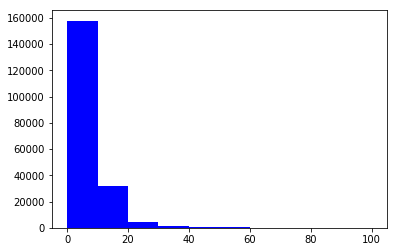

SKew is: 4.61873552901576


In [9]:
price = train_data['月租金']
plt.hist(price,color='blue')
plt.show()
print("SKew is:",price.skew())

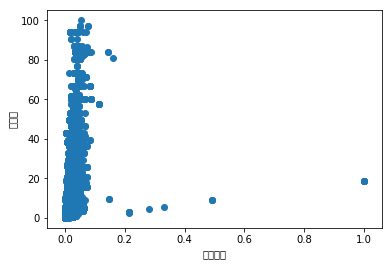

In [10]:
plt.scatter(x=train_data.房屋面积,y=train_data.月租金)
plt.xlabel("房屋面积")
plt.ylabel("月租金")
plt.show()

c:\users\samsung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


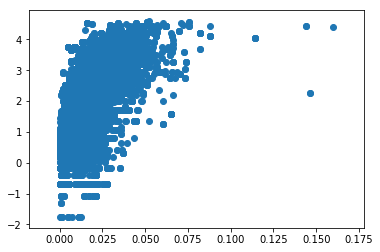

In [12]:
#删除房屋面积大于0.2但是月租金小宇50的异常点
train_data.drop(train_data[(train_data['房屋面积']>0.2)&
(train_data['月租金']<50)].index,inplace=True)
#将月租金进行对数变换
price = train_data['月租金']
target = np.log(price)
#画出散点图
plt.scatter(x = train_data['房屋面积'],y=target)
plt.show()

In [19]:
corr = train_data.corr()
print(corr['月租金'].sort_values(ascending=False)[:2])

月租金     1.00000
房屋面积    0.59289
Name: 月租金, dtype: float64


In [20]:
train_data.drop(train_data[(train_data['房屋面积']>0.6)&
(train_data['卧室数量']<2)].index,inplace=True)
train_data.drop(train_data[(train_data['房屋面积']>0.6)&
(train_data['卫的数量']<2)].index,inplace=True)
train_data.drop(train_data[(train_data['房屋面积']>0.6)&
(train_data['厅的数量']<50)].index,inplace=True)
#分析相关性
corrmat = train_data.corr()
print(corrmat['月租金'].sort_values(ascending=False))

月租金         1.000000
房屋面积        0.592890
卫的数量        0.423789
卧室数量        0.315976
出租方式        0.247789
装修情况        0.246597
厅的数量        0.221799
地铁线路        0.187696
区           0.146853
总楼层         0.139755
地铁站点        0.019555
小区房屋出租数量    0.011748
楼层          0.009543
小区名         0.007660
位置          0.006588
时间         -0.014523
距离         -0.075392
居住状态       -0.075957
Name: 月租金, dtype: float64


## 特征组合

In [ ]:
#特征提取
train_data['total'] = train_data['卧室数量'] + train_data['厅的数量'] + train_data['卫的数量']
train_data['sleep_area'] = train_data['房屋面积'] * train_data['卧室数量'] / train_data['total']
train_data['hall_area'] = train_data['房屋面积'] * train_data['厅的数量'] / train_data['total']
train_data['wash_area'] = train_data['房屋面积'] * train_data['卫的数量'] / train_data['total']
train_data['house_area'] = train_data['房屋面积'] / train_data['total']
train_data['avg_area'] = train_data['小区房屋出租数量']*train_data['房屋面积']

test_data['total'] = test_data['卧室数量'] + test_data['厅的数量'] + test_data['卫的数量']
test_data['sleep_area'] = test_data['房屋面积'] * test_data['卧室数量'] / test_data['total']
test_data['hall_area'] = test_data['房屋面积'] * test_data['厅的数量'] / test_data['total']
test_data['wash_area'] = test_data['房屋面积'] * test_data['卫的数量'] / test_data['total']
test_data['house_area'] = test_data['房屋面积'] / test_data['total']
test_data['avg_area'] = test_data['小区房屋出租数量']*test_data['房屋面积']

In [ ]:
#数据集合并
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)

In [ ]:
由于之前分析数据集有缺失数据，以及某些没有实际意义的特征列，我们予以剔除。

In [ ]:
#合并后特征填充
'''首先id是一个数据索引，没作用，剔除；
   然后查看数据文件得知，时间列只有1,2,3三个属性
   可以推断是三个月份的，其意义不大，不存在新老房之分
   然后通过corr分析相关性可知居住状态呈负相关，剔除'''
all_data.drop(['月租金'], axis=1, inplace=True)
all_data.drop(['id','时间','居住状态'], axis=1, inplace=True)
#房屋朝向用朝向出现的频率代替
tf = all_data[['房屋朝向','房屋面积']]
tf['count'] = 1
tf = tf.groupby('房屋朝向').agg('sum').reset_index()
tf.drop('房屋面积',axis =1,inplace=True)
tf['count'] = tf['count']/len(all_data)
all_data = pd.merge(all_data,tf,on='房屋朝向',how='left')
all_data.drop('房屋朝向',axis=1,inplace=True)
all_data.rename(columns={'count':'oriented'},inplace=True)

#all_data['装修情况'] = all_data['装修情况'].fillna(all_data['装修情况'].mode()[0])
#all_data['出租方式'] = all_data['出租方式'].fillna(0)
all_data['地铁线路'] = all_data['地铁线路'].fillna(0)
all_data['地铁站点'] = all_data['地铁站点'].fillna(0)
all_data['距离'] = all_data['距离'].fillna(0)
all_data['区'] = all_data['区'].fillna(all_data['区'].mode()[0])
all_data['位置'] = all_data['位置'].fillna(all_data['位置'].mode()[0])
all_data['小区房屋出租数量'] = all_data['小区房屋出租数量'].fillna(all_data['小区房屋出租数量'].mean())

In [ ]:
for f in all_data.columns:
        if all_data[f].dtype != 'float64':
            all_data[f] = all_data[f].astype('float64')

## 模型训练

In [ ]:
#调参环节
cv_params = {'reg_lambda': [0.05, 0.1, 1, 2, 3]}
other_params = {'colsample_bytree':0.6, 'gamma':0.3,
                             'learning_rate':0.1, 'max_depth':10,
                             'min_child_weight':4,'n_estimators':1500,
                             'reg_alpha':2, 'reg_lambda':1,
                             'subsample':1.0, 'silent':False,
                             'random_state':7}

model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,verbose=1,n_jobs=4)
optimized_GBM.fit(train,y_train)
evalute_result = optimized_GBM.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值:{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))


In [ ]:
#调节完之后的最佳模型参数
model_xgb = xgb.XGBRegressor(colsample_bytree=0.8, gamma=0.2,
                             learning_rate=0.05, max_depth=10,
                             min_child_weight=1, n_estimators=2226,
                             reg_alpha=0.5, reg_lambda=0.01,
                             subsample=0.8, silent=False,
                             random_state=7)

In [ ]:
#均方根函数
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
sub = pd.DataFrame()
sub['id'] = id
sub['price'] = xgb_pred
sub.to_csv('sample.csv', index=False)